# Segmentation using remote sensing image

## Importing Zip Dataset from Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import cv2
import os
import shutil
import glob

# you need to download zip file from here and locate your google drive directory
#https://drive.google.com/file/d/1lHWoNLwE3fY0dmpk0NLI21eY37qtxaha/view?usp=drive_link
#https://drive.google.com/file/d/1nlbZ6rQ26GukOO247-4cDbDEjyO5BGtR/view?usp=drive_link
train_zip = "images_crop256"
label_zip = "gt_crop256"

# modify this path
train_image_path = "/content/drive/MyDrive/dataset/AerialImageDataset/train/"
label_image_path = "/content/drive/MyDrive/dataset/AerialImageDataset/train/"


# destination colabo directory
dst_path = "/content/sample_data/"


# copy and unzip
shutil.copyfile(train_image_path + train_zip + ".zip", dst_path + train_zip + ".zip")
shutil.unpack_archive(dst_path + train_zip + ".zip", dst_path + train_zip)
shutil.copyfile(label_image_path + label_zip + ".zip", dst_path + label_zip + ".zip")
shutil.unpack_archive(dst_path + label_zip + ".zip", dst_path + label_zip)


In [3]:

train_zip = "images_crop256/images_crop256"
label_zip = "gt_crop256/gt_crop256"

train_path = dst_path + train_zip
label_path = dst_path + label_zip


train_image_paths = sorted(glob.glob(train_path + '/*.jpg'))
label_image_paths = sorted(glob.glob(label_path + '/*.jpg'))

train_image_count = len(train_image_paths)
label_image_count = len(label_image_paths)

print('number of training image = ', train_image_count)
print('number of label image = '   , label_image_count)

path_ds = tf.data.Dataset.from_tensor_slices(train_image_paths)
label_ds = tf.data.Dataset.from_tensor_slices(label_image_paths)

number of training image =  11520
number of label image =  11520




*   zipping as Dataset



In [4]:
# parameters
BATCH_SIZE = 4
IMG_HEIGHT = 256
IMG_WIDTH = 256
BUFFER_SIZE = 1000

In [5]:


#mapをつかってデータセット呼び出しに自動的に画像を変換するdatasetを作る
def preprocess_image3(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    return image

def preprocess_image1(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    return image

AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds_train = path_ds.map(preprocess_image3, num_parallel_calls=AUTOTUNE)
label_ds_train = label_ds.map(preprocess_image1, num_parallel_calls=AUTOTUNE)

train_images = tf.data.Dataset.zip((image_ds_train, label_ds_train))
print(train_images)

<_ZipDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None))>


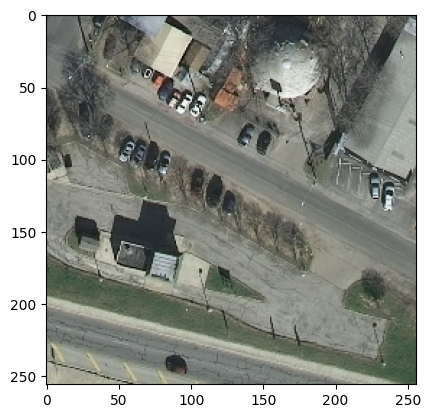

In [6]:
plt.imshow(preprocess_image3(train_image_paths[0]))

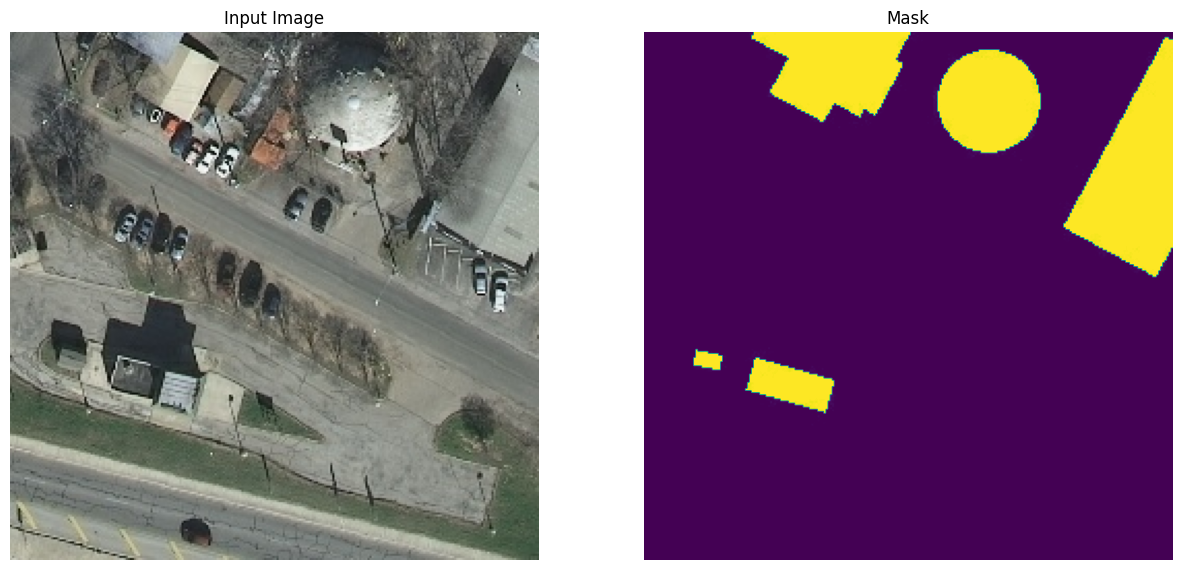

In [7]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  # test case
  if len(display_list) < 3:
    title = ['Input Image',  'Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


for images, masks in train_images.take(1):
  #sample_image, sample_mask = images[0], masks[0]
  #print(images)
  display([images, masks])




*   Data augumentation definition




In [8]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))


## Model generation


*   UNet using Transfer learning (Pre-trained Encorder)



In [9]:
!pip install git+https://github.com/tensorflow/examples.git

from tensorflow_examples.models.pix2pix import pix2pix

input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=[input_shape[0], input_shape[1], 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 128
    'block_3_expand_relu',   # 64
    'block_6_expand_relu',   # 32
    'block_13_expand_relu',  # 16
    'block_16_project',      # 8
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 8-16
    pix2pix.upsample(256, 3),  # 16-32
    pix2pix.upsample(128, 3),  # 32-64
    pix2pix.upsample(64, 3),   # 64-128
]



def unet_model(output_channels:int):

  inputs = tf.keras.layers.Input(shape=[input_shape[0], input_shape[1], 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #128-256

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)



OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-blrfl45z
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-blrfl45z
  Resolved https://github.com/tensorflow/examples.git to commit 548f701bbd258ca22edd6d1655336d594f7b4072
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1685755875.482753997327659721731712354189466050931602440306-py3-none-any.whl size=299978 sha256=953fa92e5ac8682ad0f1c146459b7b6b8c3f1cc3a230b5af39a3bfefbafb4c08
  Stored in directory: /tmp/pip-ephem-wheel-cache-a8pt04kl/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


9406464/9406464 [==============================] - 0s 0us/step


In [10]:
# showing model structure
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 128, 128, 9  1841984     ['input_2[0][0]']                
                                6),                                                               
                                 (None, 64, 64, 144                                               
                                ),                                                                
                                 (None, 32, 32, 192                                         

## Training

In [13]:
checkpoint_dir = '/content/drive/MyDrive/dataset/checkpoints'
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir + '/weights.{epoch:02d}.hdf5',
                                          # monitor='val_loss',
                                          verbose=0,
                                          save_best_only=False,
                                          save_weights_only=False,
                                          mode='auto',
                                          period=2)


model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              #loss='categorical_crossentropy', # for multi-class ch. output(e.g. one-hot) for multi-class classification
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # for scalar output for multi-class classification
              metrics=['accuracy'])

#tf.keras.utils.plot_model(model, show_shapes=True)
wlist = os.listdir(checkpoint_dir)
model.load_weights(checkpoint_dir + '/' + wlist[-1])

history = model.fit(
        train_batches,
        epochs=1, # 40
        steps_per_epoch=train_image_count//BATCH_SIZE,
        use_multiprocessing=True,
        callbacks=[ckpt_cb]
        )


model.save('unet_aerial')

2880/2880 [==============================] - 528s 182ms/step - loss: 0.0690 - accuracy: 0.9559


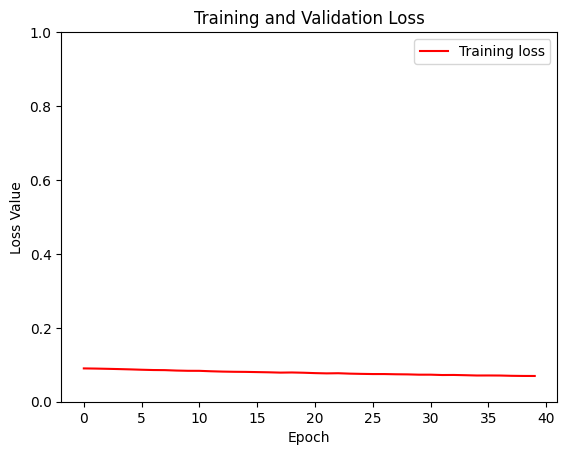

In [ ]:
loss = history.history['loss']
#val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
#plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Visualize prediction

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


1/1 [==============================] - 1s 833ms/step


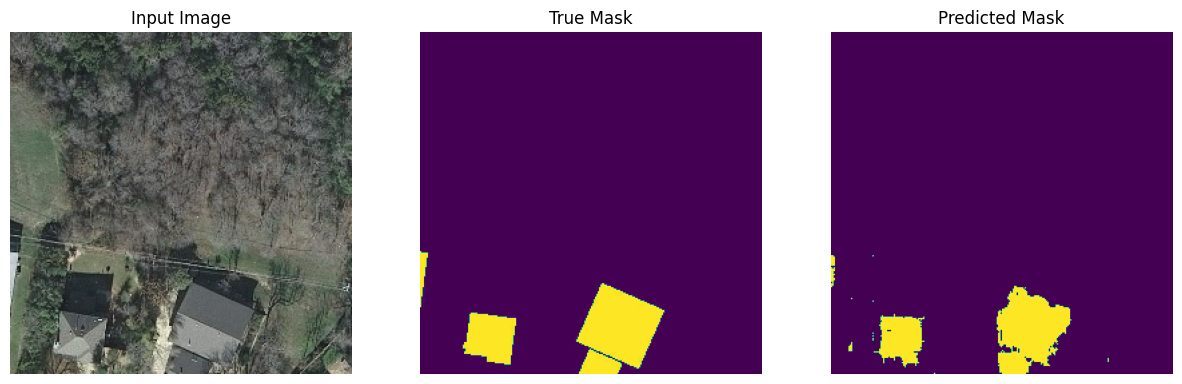

1/1 [==============================] - 0s 28ms/step


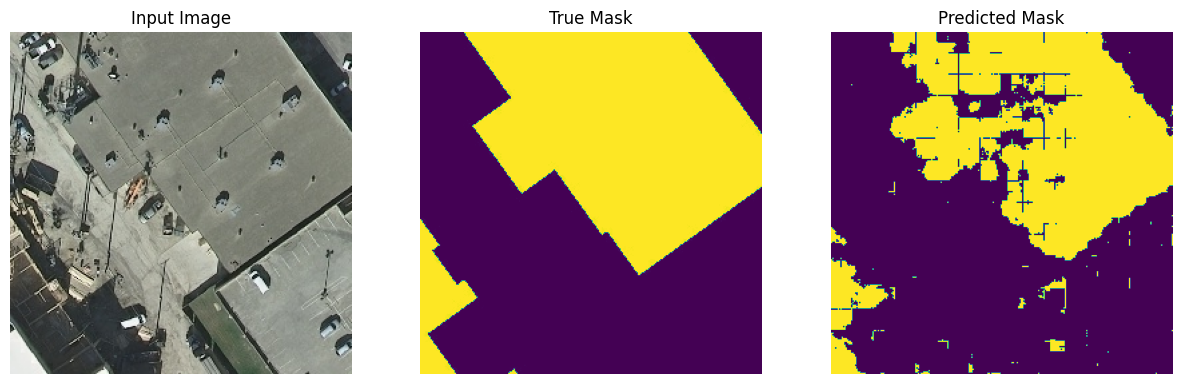

1/1 [==============================] - 0s 24ms/step


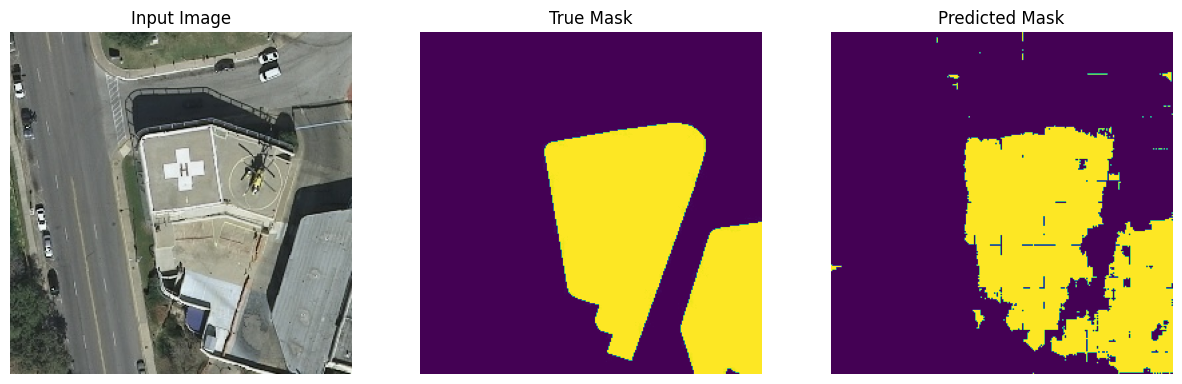

In [ ]:
show_predictions(train_batches,3)

## Test model (loading different size image from training patch size)

1/1 [==============================] - 1s 837ms/step


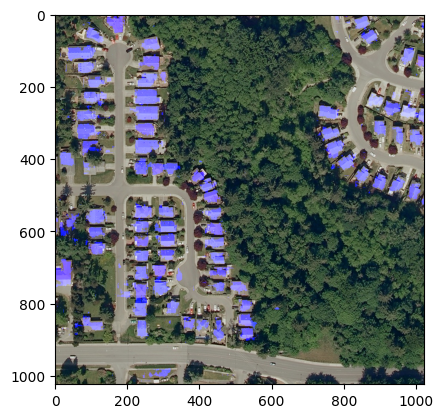

In [ ]:
# test image examples
test_image_drive_path = "/content/drive/MyDrive/dataset/AerialImageDataset/mytest/"
#test_file = "00000623_input.jpg"
#test_file = "00000696_input.jpg"
#test_file = "00000003_input.jpg"
test_file = "00000024_input.jpg"

test_size = [1024, 1024]
shutil.copyfile(test_image_drive_path + test_file, dst_path + test_file)


def show_predictions_test(image, pred_mask):
    display([image[0], create_mask(pred_mask)])

def show_predictions_test_overlay(image, pred_mask):
    #img = tf.keras.utils.array_to_img(image[0])
    #cmask = tf.keras.utils.array_to_img(create_mask(pred_mask))
    img   = image[0].numpy()
    cmask = create_mask(pred_mask).numpy()
    #print(np.shape(img))
    #img[cmask>0.0] = 255.0
    img[:,:,2] = img[:,:,2] + cmask[:,:,0]
    plt.imshow(img)
    cv2.imwrite(test_image_drive_path + test_file + "_res.jpg",img*255)


def preprocess_image3_test(path, height=test_size[0], width=test_size[1]):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, [height, width])
    return image


base_model_test = tf.keras.applications.MobileNetV2(input_shape=[test_size[0], test_size[1], 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 128
    'block_3_expand_relu',   # 64
    'block_6_expand_relu',   # 32
    'block_13_expand_relu',  # 16
    'block_16_project',      # 8
]
base_model_outputs_test = [base_model_test.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack_test = tf.keras.Model(inputs=base_model_test.input, outputs=base_model_outputs_test)
down_stack_test.trainable = False



def unet_model_test(output_channels:int, height=test_size[0], width=test_size[1]):
  inputs = tf.keras.layers.Input(shape=[height, width, 3])

  # Downsampling through the model
  skips = down_stack_test(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #128-256

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


model_test = unet_model_test(output_channels=OUTPUT_CLASSES, height=test_size[0], width=test_size[1])
model_test.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # for scalar output for multi-class classification
              metrics=['accuracy'])

checkpoint_dir = '/content/drive/MyDrive/dataset/checkpoints'
wlist = os.listdir(checkpoint_dir)
model_test.load_weights(checkpoint_dir + '/' + wlist[-1])

test_path =  dst_path + test_file
image = preprocess_image3_test(test_path,test_size[0], test_size[1])
image = tf.expand_dims(image, axis=0)
pred_mask = model_test.predict(image)

#show_predictions_test(image, pred_mask)
show_predictions_test_overlay(image, pred_mask)


In [ ]:
test_path = '/content/sample_data/00000000_input.jpg'
image = preprocess_image3(test_path)
image = tf.expand_dims(image, axis=0)
pred_mask = model.predict(image)

show_predictions_test(image, pred_mask)
#plt.imshow(tf.keras.utils.array_to_img(create_mask(pred_mask)))
plt.imshow(image)